Tensorflow is Google's open source deep learning library originally developed by researchers at Google brain. Tensorflow is being used in nearly all of Google's products, including Google search, Google photos, speech recognition, gmail and many other areas. Since becoming public, tensorflow has become very popular. 

Tensorflow supports many platforms like cpu,gpu,android,ios and Raspberry pi and models can also be run on Google cloud directly. Many higher level API's like Keras, TFSlim has been launched with tensorflow in the backend. Its also used in production with Tensorflow Serve. Tensorboard, a great visualization library for machine learning also comes with Tensorflow. 

In this tutorial, we'll cover the basics of tensorflow and work with tensorflow on a multivariable regression problem using the high level api.The challenge would be to predict price of Airbnb listings from features like property type, neighbourhood, review scores etc. [AirBNB](https://www.airbnb.com/) is a online marketplace that enables people to rent or lease short term lodging including vacation and apartment rentals, homestays, hostel beds, hotels and even entire villas. We'll get used to how to handle a variety of features(numeric, categorical, text) with Tensorflow as we work through the dataset.

![](../images/boston-airbnb.png)

As part of the Airbnb Inside initiative, this dataset has been published in [Kaggle](www.kaggle.com), a platform that hosts many open datasets and runs machine learning competitions. To know more about the original source, see [here](http://insideairbnb.com/get-the-data.html). 


# Installation

This tutorial uses tensorflow's latest release which is version 1.2.0. So you must use a version above 1.2 for running the code. Please see this [installation guide](https://www.tensorflow.org/install/) for details about how to get tensorflow. Also the cpu version will suffice for the sake of this tutorial. Guidelines and requirements for getting the gpu version is in the documentation.

Here's the links to different platform installation guides :

* [Windows](https://www.tensorflow.org/install/install_windows)
* [Linux](https://www.tensorflow.org/install/install_linux)
* [Mac OS X](https://www.tensorflow.org/install/install_mac) 

In Windows tensorflow only comes with python 3.5. So I recommend using [Anaconda](https://www.continuum.io/downloads), [creating an environment](https://conda.io/docs/py2or3.html#create-a-python-3-5-environment) with python 3.5 and then using the official guidelines for getting tensorflow.



# Prerequisites

This tutorial does not assume any familiarity with tensorflow. However it does assume basic programming skills in python, understanding of basic machine learning concepts(feature preprocessing, train-test split, loss function etc). Some experience with ```pandas``` dataframes and ```scikit-learn``` models may also help, but its completely optional.

# Tensorflow fundamentals

In Tensorflow, everything is based on the concept of creating a computational graph. A computational graph is simply a series of tensorflow operations chained into a graph structure where the later operations may/may not depend on the first operations.All tensorflow programs can be divided into two parst conceptually, 'building the computational graph' and "running the computational graph". The nodes of the graph are the mathematical operations.The edges indicate which tensors go into a node and which tensor comes out after the operation. Each operation takes 0 or more tensors as input and produces a tensor as an output or does some computation depending on the definition of the operation.

"Tensor" is the unit of the computational graph in Tensorflow. Tensors are similar to numpy arrays, they are basically multidimensional arrays. A zero dimensional tensor is a point that can be a constant or a variable. A one dimensional tensor is an array/vector. A two dimensional tensor is a ```n x m``` matrix and so on.

In [1]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)
print(tf.__version__)

1.2.0


We can define two constant tensors a and b with ```tf.constant``` and add them up with ```tf.add```.

In [2]:
a = tf.constant(1,name = "a")
b = tf.constant(5, name = "b")
result = tf.add(a,b)
result

<tf.Tensor 'Add:0' shape=() dtype=int32>

Even if we have run the function ```tf.add```, the code has not performed any computations "yet", rather it has simply built a computational graph. A graph just defines the operations that we want to perform. To evaluate ```result``` we have to run the code under a Tensorflow 'session'. A session takes a computational graph or part of a graph and executes it. It also holds the intermediate values and the results of performing the computation.

Following code creates a Tensorflow session, and evaluates the output. See this [tutorial](https://danijar.com/what-is-a-tensorflow-session/) for understanding the difference between tensorflow graph and session. 

In [3]:
with tf.Session() as sess:
    result = result.eval()
result

6


# Tensorboard 

Tensorboard is a data visualization tool that comes packaged with tensorflow. To visualize that all of the operations happen inside a computational graph, we can use Tensorboard. Each operation gets stored into the default computational graph unless we specifically create another graph. We can save our graphs with by writing [summaries](https://www.tensorflow.org/api_guides/python/summary) about them with [summary writers](https://www.tensorflow.org/api_docs/python/tf/summary/FileWriter). Tensorboard creates visualizations out of these event log files.

Here we pass a log directory and a computational graph into the summary writer object to save our computational graph. ```sess.graph``` contains the default computational graph for this session and ```writer``` writes it into the path provided in ```logdir```.  Note we have reset the default graph here to visualize only this sum operation instead of the former ones in the above examples. 

In [4]:
tf.reset_default_graph()

a = tf.constant(1, name = "a")
b = tf.constant(5, name = "b")

with tf.Session() as sess:
    result  = tf.add(a,b, name = "sum").eval()
    writer = tf.summary.FileWriter(logdir= "../first_graph",graph = sess.graph)


To run TensorBoard, use the following command in the terminal 

```tensorboard --logdir=path/to/log-directory```

In windows, use ```tensorboard --logdir path/to/log-directory```. 

Here logdir is ```../newgraph2```, so we can simply type

```tensorboard --logdir=first_graph```

Tensorboard's default port is 6006. So if you go to http://localhost:6006/#graphs tensorboard will be there. If we go under the graphs section we can see this visualization of our tiny computational graph. The node is a mathematical operation sum that takes in two inputs a and b.

![kk](../images/graph1.png)



# Tensorflow high level API 

If we were coding models from scratch we would have to define each variables, constants, matrices, write code for all the mathematical operations and train them under a session, which is difficult and error prone. Luckily Tensorflow's high level api ```tf.contrib.learn```(former ```skflow```) makes it easy to use many popular machine learning models including linear models, random forest, clustering and neural network by providing fully functional models that can be used out of the box. Skflow was originally a simplified interface for tensorflow that mimicked scikit-learn interface, but it has been merged with tensorflow.


Canned models in the ```tf.contrib.learn``` library are called [```estimators```](https://www.tensorflow.org/api_docs/python/tf/contrib/learn/Estimator) . Estimators are the basic tensorflow model trainer and evaluator. These come with ```fit```, ```evaluate``` and ```predict``` methods like scikit-learn. We can also export the trained models.

Now we are going to use the high level models to work on the regression problem with airbnb data. Data can be downloaded from Kaggle by using this link : [Boston Airbnb Open Data, Kaggle](https://www.kaggle.com/airbnb/boston) if you want to follow along with the code. We'll use two models in the tutorial, one linear and another neural network model.


We'll follow this workflow to work with tensorflow's high level api :

* Load the data and the libraries 
* Prepare the dataset for machine learning 
* Split the dataset into training and test set
* Define the feature columns
* Instantiate the model
* Feed the features to the model with an input function
* Fit and evaluate the model
* Generate the predictions 


## Load the dataset 

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
plt.style.use("seaborn")
%matplotlib inline

## Dataset 

The dataset has ```3585``` rows and ```95``` columns. However we will only use a subset of the features.These features will be used :  

* ```property_type``` : Categorical. Describes the type of the property. 
* ```room_type``` : Categorical. Describes the type of the room.
* ```bathrooms``` : Number of Bathrooms.
* ```bedrooms``` : Number of bedrooms.
* ```amenities``` : A string describing all the facilities provided by the property.
* ```beds``` : Number of beds.
* ```bed_type``` : Type of the bed in listing. Categorical feature. 
* ```accommodates``` : Number of people the rental will accommodate. 
* ```host_total_listings_count```: Number of listings posted by the host.
* ```number_of_reviews```: Number of reviews received by the rental.
* ```review_scores_value``` : Average value of the reviews for this listing.
* ```neighbourhood_cleansed``` : Categorical feature. Describes the neighbourhood of the rental.
* ```cleaning_fee``` : Cleaning fee for the rental.
* ```minimum_nights``` : Minimum nights the guest must stay to be considered for rental.
* ```security_deposit``` : Amount of security deposit the guest has to pay to the host before renting.
* ```host_is_superhost``` : Categorical. True if the host is a superhost. False otherwise.
* ```instant_bookable``` : Categorical.True if the rental is instantly bookable. False Otherwise.
* ```price``` : Continuous target variable for the regression task.



Now we'll load the dataset with ```pandas```. Tensorflow integrates well with ```pandas``` and provides many useful functions to work with it.

In [6]:
used_features = ['property_type','room_type','amenities','bathrooms','bedrooms','beds','bed_type','accommodates','host_total_listings_count'
                ,'number_of_reviews','review_scores_value','neighbourhood_cleansed','cleaning_fee','minimum_nights','security_deposit','host_is_superhost',
                 'instant_bookable', 'price']

boston = pd.read_csv('../dquestarticle/boston_listings.csv', usecols = used_features)
print(boston.shape)
boston.head(2)

(3585, 18)


,host_is_superhost,host_total_listings_count,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,minimum_nights,number_of_reviews,review_scores_value,instant_bookable
0,f,1,Roslindale,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",$250.00,NaN,$35.00,2,0,NaN,f
1,f,1,Roslindale,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",$65.00,$95.00,$10.00,2,36,9.0,t


## Data Preprocessing 

To use the features in our tensorflow model, we need to convert them to Tensors. But before that we need to take some more data cleaning steps to prepare our data for machine learning. Here's a brief overview of the cleaning steps. 

*  ```price```, ```security_deposit``` and ```cleaning_fee``` are numbers, but they are loaded as strings.These numbers also contain some non-numeric characters (```$ and ,```). We'll remove the non-numeric characters from the features, convert them to ```float``` and fill the missing values with the median value of each feature. 

* Similarly, some other features like ```bathroom```, ```bed``` has some missing values which are also filled with the median.

* ```property_type``` is a categorical variable. The missing values are filled with the most common category ```Apartment```.

In [7]:
for feature in ["cleaning_fee","security_deposit","price"]:
    boston[feature] = boston[feature].map(lambda x:x.replace("$",'').replace(",",''),na_action = 'ignore')
    boston[feature] = boston[feature].astype(float)
    boston[feature].fillna(boston[feature].median(),inplace = True)
    
    
for feature in ["bathrooms","bedrooms","beds","review_scores_value"]:
    boston[feature].fillna(boston[feature].median(),inplace = True)
    
boston['property_type'].fillna('Apartment',inplace = True)

Before moving on to the other features, we check our target variable ```price```. 

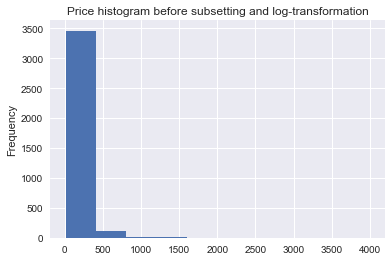

In [8]:
boston["price"].plot(kind = 'hist',grid = True)
plt.title("Price histogram before subsetting and log-transformation");


In the histogram we  can see most of the data falls under 500. So we'll use a subset of our dataset where the price ranges from 50-500 for now to remove very large or very small prices.We'll also log-transform the target variable to improve the linearity of the data.

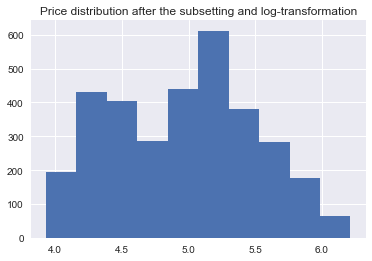

In [9]:
boston = boston[(boston["price"]>50)&(boston["price"]<500)]
target = np.log(boston.price)
target.hist()
plt.title("Price distribution after the subsetting and log-transformation");

```amenities``` feature is a string that contains all the facilities this rental provides. Let's look at an instance. The reason for including this feature is to show how to handle different sort of categorical columns. We'll transform this feature into a Dataframe that would say for each instance some facility like air conditioner or doorman is present for that listing or not.

In [10]:
boston["amenities"][0]

'{TV,"Wireless Internet",Kitchen,"Free Parking on Premises","Pets live on this property",Dog(s),Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Fire Extinguisher",Essentials,Shampoo,"Laptop Friendly Workspace"}'

First we removed the extra non-alphabetical characters like brackets.Then we converted this string to features using the [```pd.Series.str.get_dummies```](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.get_dummies.html) method which makes a DataFrame out of the strings by splitting it on a seperator. 

We also drop two columns that has missing translation names because its not obvious what these features are.

In [11]:
amenities = boston["amenities"].str.replace('[{}"]','')
amenities = amenities.str.get_dummies(sep=",")
amenities.columns = amenities.columns.str.replace(" ","_").str.replace("[()]","")

drop_columns  = ['translation_missing:_en.hosting_amenity_49',
       'translation_missing:_en.hosting_amenity_50']
amenities.drop(drop_columns,axis=1,inplace=True)
amenities.head(2)

,24-Hour_Check-in,Air_Conditioning,Breakfast,Buzzer/Wireless_Intercom,Cable_TV,Carbon_Monoxide_Detector,Cats,Dogs,Doorman,Dryer,...,Safety_Card,Shampoo,Smoke_Detector,Smoking_Allowed,Suitable_for_Events,TV,Washer,Washer_/_Dryer,Wheelchair_Accessible,Wireless_Internet
0,0,0,0,0,0,0,0,1,0,1,...,0,1,1,0,0,1,1,0,0,1
1,0,1,0,0,0,1,0,1,0,1,...,0,1,1,0,0,1,1,0,0,1


At last we merge the two Dataframes containing the base features from the ```boston``` Dataframe and the derived features from the ```amenities``` Dataframe using [```pd.concat```](http://pandas.pydata.org/pandas-docs/version/0.20/generated/pandas.concat.html) into one dataframe named ```features```. This is the end of our preprocessing. 

In [12]:
features = pd.concat([boston.drop(["amenities","price"],axis=1),amenities],axis=1)
features.head(2)
print(features.shape)
print(target.shape)

(3269, 59)
(3269,)


## Split the Data 

Now that we have our features and the target, we can use scikit-learn to split the data. Scikit-learn provides a ```train_test_split``` function for splitting a pandas DataFrame into a training and testing set. ```train_test_split``` accepts the features and the target as parameters and returns the randomly shuffled data. We have 33% of the data in the training set and the rest is in the test set. We could also use numpy or tensorflow itself for splitting it, we just use scikit learn for ease.

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
     features, target, test_size=0.33, random_state=42)

## Define Feature Columns

When we instantiate a tensorflow estimator (create an object of the estimator class) we have to pass a list of feature columns to the ```feature_column``` parameter. [```FeatureColumns```](https://www.tensorflow.org/api_docs/python/tf/feature_column) provide a high level abstraction for ingesting and representing features in tf.learn Estimator models. Feature columns specify the data types for each of the features in our estimator.

Tensorflow provides many different ways to handle the features. The type of Feature column to use depends on the feature type and the model type.

* Feature type : Numeric and categorical features need to be handled differently.
* Model type : Linear models and the neural network models handle categorical features differently.

In this tutorial we'll show how to handle numeric and the categorical features. First we'll get the column names of the numeric features and the categorical features seperately using ```pandas.DataFrame.column``` that returns a list of column names of a dataframe. We could handle the features one by one too, depending on how we'll use them. ```pandas.DataFrame.select_dtypes``` help us to filter a dataframe based on the datatype of each column.

In [14]:
# Get all the numeric feature names

numeric_columns = boston.select_dtypes(exclude=["object"]).columns.drop("price")

# Get all the categorical feature names that contains strings

categorical_columns = features.columns.drop(numeric_columns)



Numeric features can be represented by [```numeric_column```](https://www.tensorflow.org/api_docs/python/tf/feature_column/numeric_column) which is used for real valued or numerical features. When we create a ```numeric_column``` we have to pass a unique string to its e ```key``` parameter. The value of ```key``` will be used as the name of the column and also as the dictionary key that maps to the values of this feature when we'll feed the data during training. Refer to the documentation for learning about other parameters.

In [15]:
numeric_features = [tf.feature_column.numeric_column(key = column) for column in numeric_columns]
numeric_features[0]

_NumericColumn(key='host_total_listings_count', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)

There are many ways to handle categorical features. [```categorical_column_with_vocabulary_list```](https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_vocabulary_list) is just one of them. Its used when the inputs are in string or integer format and we already know the set of all possible values this categorical feature may take. If we don't know the possible categories or if there's too many possible values for a category(e.g countries, states etc), we can use [```categorical_column_with_hash_bucket```](https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_hash_bucket) instead.

```categorical_column_with_vocabulary_list``` must have following inputs : 

* key : a unique string identifying the input feature which would be used as the name of the column.
* vocabulary_list : An ordered iterable defining the possible values for this categorical feature

For linear models I've found using this one has advantage over the one using hashing because it's easy to visualize the weights.

In [16]:
categorical_features = [tf.feature_column.categorical_column_with_vocabulary_list(key = column, 
                                                                                 vocabulary_list = features[column].value_counts().keys()
                                                                                 ) for column in categorical_columns]

categorical_features[3]

_VocabularyListCategoricalColumn(key='room_type', vocabulary_list=('Entire home/apt', 'Private room', 'Shared room'), dtype=tf.string, default_value=-1)

We combine all the numeric and the categorical feature columns to one list containing all of them.

In [17]:
linear_features = numeric_features + categorical_features 

## Create linear model 

We instantiate the linear model by passing the list containing the feature columns to the ```feature_columns``` parameter. We also specify a model directory with the ```model_dir``` parameter because tensorflow will store the model graph and the checkpoints in that directory which we can later visualize with Tensorboard.

In [18]:
linear_regressor = tf.contrib.learn.LinearRegressor(feature_columns=linear_features,model_dir = "../linear_regressor")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_tf_random_seed': None, '_num_ps_replicas': 0, '_session_config': None, '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_steps': None, '_master': '', '_save_checkpoints_secs': 600, '_evaluation_master': '', '_model_dir': '../linear_regressor', '_save_summary_steps': 100, '_num_worker_replicas': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000005EB0B7ABE0>, '_keep_checkpoint_max': 5, '_task_id': 0, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_environment': 'local', '_is_chief': True}


## Fit the model


The ```estimators``` expect an input function to be passed into the ```input_fn``` parameter of the fit method when training the model. This input function will feed the training data to the model when training by returning a mapping of the feature columns to tensors ( a dictionary where the keys are the names of the feature columns and the values are the training data converted into tensors) and labels. 

Input functions can be super simple like just returning the numpy arrays containing the features and the label or really complex. Complex input functions does the preprocessing for converting the features to tensors.

The structure of an input function looks like this. 

```def my_input_fn():```

    # Preprocess your data here...

    # ...then return 1) a mapping of feature columns to Tensors with
    # the corresponding feature data, and 2) a Tensor containing labels
    return feature_cols, labels

For learning more about the input functions, see this tutorial in the documentation named ["Building Input functions"](https://www.tensorflow.org/get_started/input_fn).

Luckily tensorflow provides functionality for feeding a pandas Dataframe straight into a tensorflow estimator with the ```pandas_input_fn``` function. [```pandas_input_fn```](https://www.tensorflow.org/versions/master/api_docs/python/tf/estimator/inputs/pandas_input_fn) has many parameters but we will use the following. 

* ```x``` : pandas ```DataFrame``` object.
* ```y``` : pandas ```Series``` object. None if absent
* ```batch_size``` : int, size of batches to return
* ```shuffle``` : boolean. whether to read the data in random order
* ```num_epoch``` : int. number of epoches to iterate over the data.one epoch is going over all the training data once. None means it will cycle through input data forever.

Note that ```pandas_input_fn``` returns an input function that would feed the data to the tensorflow model. Here we create two input functions ```training_input_fn``` and ```eval_input_fn``` that takes the training and test set features and labels respectively. 

We set the ```shuffle``` parameter to False as the data was already shuffled when we create the training and testing sets. ```num_epoch``` is set to ```None``` in the ```training_input_fn``` because we want to go over the training dataset multiple times as the model trains. The default value of ```num_epoch``` is 1 and we want to go over the test dataset only once to evaluate the model, so we let it remain as it is.

In [19]:
# Create training input function

training_input_fn = tf.estimator.inputs.pandas_input_fn(x = X_train,y=y_train,batch_size=32,shuffle=False, num_epochs = None)

# create testing input function 

eval_input_fn = tf.estimator.inputs.pandas_input_fn(x=X_test,y=y_test,batch_size=32,shuffle=False)

We pass the ```training_input_fn``` to the ```input_fn``` parameter of the ```fit``` method and specify the number of steps we want to train the model. Note that we simply need to pass the function to the fit method, not the return value of a function call. So it'd be ```input_fn = training_input_fn``` instead of ```input_fn = training_input_fn()```. Adding the brackets after the function name will evaluate the function instead of just passing it.

In [20]:
linear_regressor.fit(input_fn = training_input_fn,steps=2000)

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into ../linear_regressor\model.ckpt.
INFO:tensorflow:loss = 26.7607, step = 1
INFO:tensorflow:global_step/sec: 47.3151
INFO:tensorflow:loss = 0.14979, step = 101 (2.083 sec)
INFO:tensorflow:global_step/sec: 73.803
INFO:tensorflow:loss = 0.105706, step = 201 (1.355 sec)
INFO:tensorflow:global_step/sec: 73.8027
INFO:tensorflow:loss = 0.154987, step = 301 (1.357 sec)
INFO:tensorflow:global_step/sec: 70.9218
INFO:tensorflow:loss = 0.0873958, step = 401 (1.403 sec)
INFO:tensorflow:global_step/sec: 68.9162
INFO:tensorflow:loss = 0.132903, step = 501 (1.450 sec)
INFO:tensorflow:global_s

LinearRegressor(params={'optimizer': None, 'joint_weights': False, 'gradient_clip_norm': None, 'feature_columns': [_NumericColumn(key='host_total_listings_count', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='accommodates', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='bathrooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='bedrooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='beds', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='security_deposit', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='cleaning_fee', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='minimum_nights', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='number_of_rev

## Evaluate the model

For evaluating the model we simply pass the ```eval_input_fn``` to the ```input_fn``` parameter in ```regressor.evaluate``` method as we did earlier with the ```fit``` method. It returns a ```dict``` containing loss after evaluating the model on the test set. Currently loss is defined as mean squared error(MSE) in the ```LinearRegressor``` model. If you want to build your own estimator see this [tutorial](https://www.tensorflow.org/extend/estimators).

In [21]:
loss = linear_regressor.evaluate(input_fn = eval_input_fn)['loss']
print("Loss is " + str(loss))

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-08-25-20:03:45
INFO:tensorflow:Restoring parameters from ../linear_regressor\model.ckpt-2000
INFO:tensorflow:Finished evaluation at 2017-08-25-20:03:52
INFO:tensorflow:Saving dict for global step 2000: global_step = 2000, loss = 0.0920125
Loss is 0.0920125


```LinearRegressor.predict_scores``` method returns a ```generator``` for yielding predictions. Since we have set the ```num_epoch``` to 1 the input function we are using to feed the data to the evaluation function will go over the test dataset only once. We can easily convert it to a list for getting the predictions.

In [22]:
pred = list(linear_regressor.predict_scores(input_fn = eval_input_fn))

INFO:tensorflow:Restoring parameters from ../linear_regressor\model.ckpt-2000


We can use the R^2 score([r2 score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html))for further evaluating the linear model. Maximum R^2 score is 1. The closer the score is to 1 the better the model. 

In [23]:
from sklearn.metrics import r2_score
r2_score(y_test,pred)

0.66349228249868974

This model has a R^2 score of 0.62 which is not that bad for a linear model. We can also visualize the results with matplotlib.

''

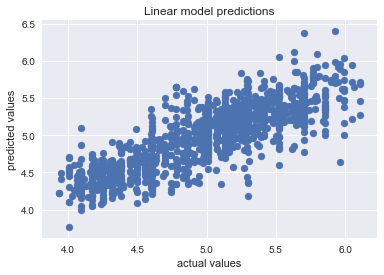

In [24]:
plt.scatter(y_test,pred,alpha = 1)
plt.xlabel("actual values")
plt.ylabel("predicted values")
plt.title("Linear model predictions")
;

## Visualizing Feature Weights

We may want to check the feature weights for the ```linear_regressor``` model. We can find the variable names for each feature from the model by using the ```get_variable_names``` method first and then get the weights by using those names. Here we demonstrate how to get the feature weights for the neighbourhoods and visualize them with a ```pandas``` dataframe for convinience. 

First we check how the variable names look like by printing a few names.

In [25]:
linear_regressor.get_variable_names()[1:2]

['linear/linear_model/24-Hour_Check-in/weights']

Then we get the feature weights for the ```neighbourhood_cleansed``` categorical feature and store them in ```property_weights```. I've made a Dataframe with the feature weights as values and the different neighbourhood names as index
for convinience. 

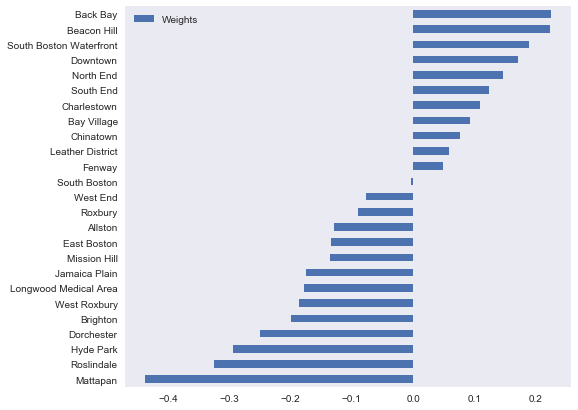

In [26]:
property_weights = linear_regressor.get_variable_value('linear/linear_model/neighbourhood_cleansed/weights').flatten()
property_keys = boston["neighbourhood_cleansed"].value_counts().keys()
pd.DataFrame({"Weights":property_weights},index=property_keys).sort_values("Weights",ascending=True).plot(kind="barh", 
                                                                                                          figsize= (8,7), 
                                                                                                          grid = False
                                                                                                         );

## Visualize Linear Model with Tensorboard 

As mentioned earlier, Tensorboard makes visualizing any model really easy. We simply need to set the ```logdir``` parameter to the directory we have saved our high level model when we want to visualize the model. Remember when we instantiated the model we can set the ```model_dir``` parameter to store the model. Tensorflow automatically save checkpoints and the details of the models under the hood in the model directory and we visualize them with tensorboard. 

Let's visualize our linear model with Tensorboard first. Type the following commands in the terminal

```tensorboard --logdir=linear_regressor``` 

or 

```tensorboard --logdir linear_regressor```  (for windows)

We can visualize the loss curve under scalars and see the model under Graphs section.

![](../images/loss_linear.png)

Also the sub-graphs can be visualized by clicking on them.

![](../images/linear_graph.png)


# Using Neural Network Model

Tensorflow makes creating neural networks and training them really easy with its high level api. To make [regular feed forward neural networks](https://en.wikipedia.org/wiki/Feedforward_neural_network), we simply have to specify how many nodes we want in each layer when we create the neural network model. 


Numerical features can be fed into a neural network without any change. But categorical features should be converted to ```indicator_column``` or ```embedding_column``` to feed them into the network. Indicator columns provide multi-hot representation of given categorical column but sparse features(columns containing mostly 0s) should be converted to the embedding columns. Here most features are actually not sparse, so we simply use the ```indicator_columns```.

We'll convert all of our categorical features to their one hot representation now with ```indicator_columns```.

In [27]:
indicator_features = [tf.feature_column.indicator_column(feature) for feature in categorical_features]

Again we get all the numeric and categorical features and instantiate the model.

In [28]:
dnn_features = numeric_features + indicator_features 
dnnregressor = tf.contrib.learn.DNNRegressor(feature_columns=dnn_features, hidden_units=[10,20,10],model_dir="../dnnregressor")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_tf_random_seed': None, '_num_ps_replicas': 0, '_session_config': None, '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_steps': None, '_master': '', '_save_checkpoints_secs': 600, '_evaluation_master': '', '_model_dir': '../dnnregressor', '_save_summary_steps': 100, '_num_worker_replicas': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000005EC105C668>, '_keep_checkpoint_max': 5, '_task_id': 0, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_environment': 'local', '_is_chief': True}


We pass the input function just like the linear regression model to train it.

In [29]:
dnnregressor.fit(input_fn=training_input_fn, steps=2000)

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into ../dnnregressor\model.ckpt.
INFO:tensorflow:loss = 396.481, step = 1
INFO:tensorflow:global_step/sec: 76.9869
INFO:tensorflow:loss = 0.409653, step = 101 (1.312 sec)
INFO:tensorflow:global_step/sec: 91.5938
INFO:tensorflow:loss = 0.354349, step = 201 (1.082 sec)
INFO:tensorflow:global_step/sec: 90.5154
INFO:tensorflow:loss = 0.420461, step = 301 (1.110 sec)
INFO:tensorflow:global_step/sec: 92.1004
INFO:tensorflow:loss = 0.244596, step = 401 (1.081 sec)
INFO:tensorflow:global_step/sec: 93.4788
INFO:tensorflow:loss = 0.243267, step = 501 (1.077 sec)
INFO:tensorflow:global_step

DNNRegressor(params={'embedding_lr_multipliers': None, 'hidden_units': [10, 20, 10], 'feature_columns': (_NumericColumn(key='host_total_listings_count', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='accommodates', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='bathrooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='bedrooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='beds', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='security_deposit', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='cleaning_fee', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='minimum_nights', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='number_of_reviews', sha

We evaluate the model by passing the input function for the test dataset.

In [30]:
dnnregressor.evaluate(input_fn = eval_input_fn)


Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-08-25-20:08:36
INFO:tensorflow:Restoring parameters from ../dnnregressor\model.ckpt-2000
INFO:tensorflow:Finished evaluation at 2017-08-25-20:08:39
INFO:tensorflow:Saving dict for global step 2000: global_step = 2000, loss = 0.125167


{'global_step': 2000, 'loss': 0.12516657}

It looks like the model has 0.09 as loss, which is roughly same as the linear regressor model, but we can easily change the neural network model structure by varying the number of hidden units in each layer with the ```hidden_units``` parameter and see if we can improve the results. We can generate predictions like before and visualize them.

INFO:tensorflow:Restoring parameters from ../dnnregressor\model.ckpt-2000


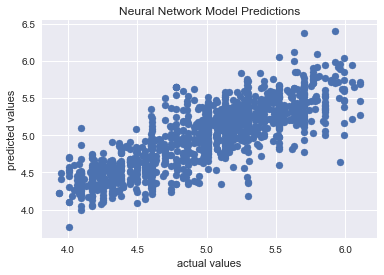

In [31]:
dnnpred = list(dnnregressor.predict_scores(input_fn=eval_input_fn))
plt.scatter(y_test,pred,alpha = 1)
plt.xlabel("actual values")
plt.ylabel("predicted values")
plt.title("Neural Network Model Predictions");

We can visualize the loss and the model using Tensorboard, but we have to pass the model directory for the neural network model here.


![](../images/loss_dnn.png)


We can see the hidden layers of the model by selecting that subgraph.

![](../images/dnn2.png)


# Recap

To summarize, we have used two regression ```estimators``` here. First one is a linear model and the second one is a neural network model. For using them we have done some data cleaning in the beginning. Then we defined the feature columns and instantiated the model. For training the models we called the ```fit``` method and fed the data to the model using an input function. After that we evaluated the model with the ```evaluate``` method and visualized the predictions. We have also learnt how to visualize the loss and the models using Tensorboard.


# Next steps : 

* Use the same techniques on a different dataset. See [18 places to find datasets for your project](https://www.dataquest.io/blog/free-datasets-for-projects/) by Dataquest to find a good dataset you may like.

* Tensorflow's high level api comes with many more models including the ones for classification and Tensorforest, K-nearest etc. Explore [these](https://www.tensorflow.org/api_docs/python/tf/contrib/learn) and apply on a dataset of your choice.

* If you are familiar with advanced deep learning topics like convolutional neural network, LTSM networks etc, use the [Keras](https://keras.io/) library for practice. Keras is another high level api representation of tensorflow that comes with it.

* [Create](https://www.tensorflow.org/extend/estimators) your own estimator! 

# References

* https://www.tensorflow.org/tutorials/linear
* https://www.tensorflow.org/get_started/tflearn
* [Effective Tensorflow for non experts](https://www.youtube.com/watch?v=5DknTFbcGVM&t=13s)
* https://www.tensorflow.org/get_started/input_fn
* https://www.tensorflow.org/tutorials/wide_and_deep